In [1]:
#Part 3: Twitter Application Development

# Team Members:
# Anant Gupta
# Jayant Solanki

In [2]:
library(maptools)
library(twitteR)
library(ggplot2)
library('ggmap')
library(maps)
library(mapdata)

Warning message:
"package 'maptools' was built under R version 3.4.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.4.3"Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()
Warning message:
"package 'twitteR' was built under R version 3.4.3"Warning message:
"package 'ggplot2' was built under R version 3.4.3"Warning message:
"package 'ggmap' was built under R version 3.4.3"Warning message:
"package 'mapdata' was built under R version 3.4.3"

In [3]:
#Here we are setting up the twitter api for use
api_key <- "xxxx" 
api_secret <- "xxxx" 
token <- "xxxx" 
token_secret <- "xxxx"
setup_twitter_oauth(api_key, api_secret, token, token_secret)

[1] "Using direct authentication"


In [4]:
# Here we are collecting the tweet having any of these keywords "flu OR #flu OR influenza OR #Influenza OR fever OR #fluseason"
# Geocode argument is used by passing the longitude and latitude values for the centre of the US and the radius value as 
# 3881 miles to cover the entire reagon of US
# In this example we have taken multiple tags in the same searchTwitter query. But in the actual implementation we collected 
# the tweets separately for flu and influenza/fever keywords

tweets <- searchTwitter("flu OR #flu OR influenza OR #Influenza OR fever OR #fluseason", n = 1000, geocode = '42.877742,-97.380979,3881mi',since="2018-02-03", lang = "en")
tweets_df <-twListToDF(tweets)


# We are saving the tweets collected in a csv file
#write.csv(tweets_df, "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/RawTweets.csv")

In [5]:
# Here we are getting the finding the unique screen names and then looking up for the corresponding profile using lookupUsers function
# After geting the users we are cleaning the result to remove any values that might create discrepancy
# Finally we are saving the locations in a csv file

screenNames <- unique(tweets_df$screenName)
screenNames <- unique(tweets_df$screenName)
userDF <- twListToDF(lookupUsers(screenNames))
screenNamedf <- data.frame(userDF$screenName,userDF$location)
colnames(screenNamedf) <- c("ScreenName","Location")
screenNamedf <- na.omit(screenNamedf)
screenNamedf <- screenNamedf[length(screenNamedf$Location) != 0,]
screenNamedf <- screenNamedf[screenNamedf$Location != " ",]
screenNamedf <- screenNamedf[screenNamedf$Location != "",]
screenNamedf <- screenNamedf[screenNamedf$Location != "   ",]


#write.csv(screenNamedf, paste("C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/ScreenName_Location.csv"))

In [6]:
#Here we are loading the csv file saved earlier which has the Location details and use the geocode function to get the latitude
# and longitude values for each tweets. Here we have loaded only few location to save time.
# Finally all the Long and Lat values were saved in a csv file and the process was repeated, since we can get only 2.5k
# geo-location per day


path <- "ScreenName_Location(Flu).csv"
plot <- read.csv(file=path,sep=",")
geocode <- geocode(as.character(plot$Location[1:20]))
plotPoints <- data.frame(geocode)
plotPoints <- na.omit(plotPoints)


#write.csv(plotPoints, "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/Lon_Lat(Flu).csv")

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=ohio--chicago--california&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Indianapolis&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=United%20States&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=New%20Hampshire%20/%20Vermont&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=California&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Circle%20Pines,%20MN%20USA%20%3Ced%3E%3CU+00A0%3E%3CU+00BC%3E%3Ced%3E%3CU+00B7%3E%3CU+00BA%3E%3Ced%3E%3CU+00A0%3E%3CU+00BC%3E%3Ced%3E%3CU+00B7%3E%3CU+00B8%3E&sensor=false
Warning message:
"geocode failed with status ZERO_RESULTS, location = "Circle Pines, MN USA <ed><U+00A0><U+00BC><ed><U+00B7><U+00BA><ed><U+00A0><U+00BC><ed><U+00B7><U+00B8>""Information fr

In [7]:
# Here we are loading the csv file which contains the longitude and latitude values of all the tweets
# And then we are using the latlong2state function to get the state name from the lon-lat values
# We have referred https://gist.github.com/rweald/4720788 for lonlat2state function

path <- "Lon_Lat(Flu).csv"
plot <- read.csv(file=path,sep=",")
plot <- data.frame(plot$lon,plot$lat)

latlong2state <- function(pointsDF) {
  states <- map('state', fill=TRUE, col="transparent", plot=FALSE)
  IDs <- sapply(strsplit(states$names, ":"), function(x) x[1])
  states_sp <- map2SpatialPolygons(states, IDs=IDs, proj4string=CRS("+proj=longlat +datum=wgs84"))
  pointsSP <- SpatialPoints(pointsDF,proj4string=CRS("+proj=longlat +datum=wgs84"))
  indices <- over(pointsSP, states_sp)
  stateNames <- sapply(states_sp@polygons, function(x) x@ID)
  stateNames[indices]
}
                       
state_name <- latlong2state(plot)
state_name <- na.omit(state_name)
                       
#write.csv(state_name, "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Lab1/P3/State(Flu).csv")

In [8]:
# Frequency of tweets statewise for FLU DATASET
# Here we use the statenames data and then create a table which shows the frequency of tweets in each state
# We have saved states names differently for teweets with Flu and Influenza tags in it
# In this cell we are first loading the tweets dataset having FLu tags in it


path <- "State(Flu).csv"
state_name <- read.csv(file=path,sep=",")
state <- table(state_name$x)
flu_statedata <- as.data.frame(state)
colnames(flu_statedata) <- c("StateName","Frequency")
flu_statedata

StateName,Frequency
alabama,21
arizona,11
arkansas,12
california,73
colorado,29
connecticut,23
delaware,5
district of columbia,36
florida,75
georgia,69


In [9]:
# Frequency of tweets statewise for Influenza DATASET
# In this cell we are first loading the tweet dataset having Influenza tags in it and then building a table to get the 
# frequency in each state


path <- "State(Influenza).csv"
state_name <- read.csv(file=path,sep=",")
state <- table(state_name$x)
influenza_statedata <- as.data.frame(state)
colnames(influenza_statedata) <- c("StateName","Frequency")
influenza_statedata

StateName,Frequency
alabama,3
arizona,19
arkansas,35
california,34
colorado,48
connecticut,4
delaware,1
district of columbia,3
florida,16
georgia,8


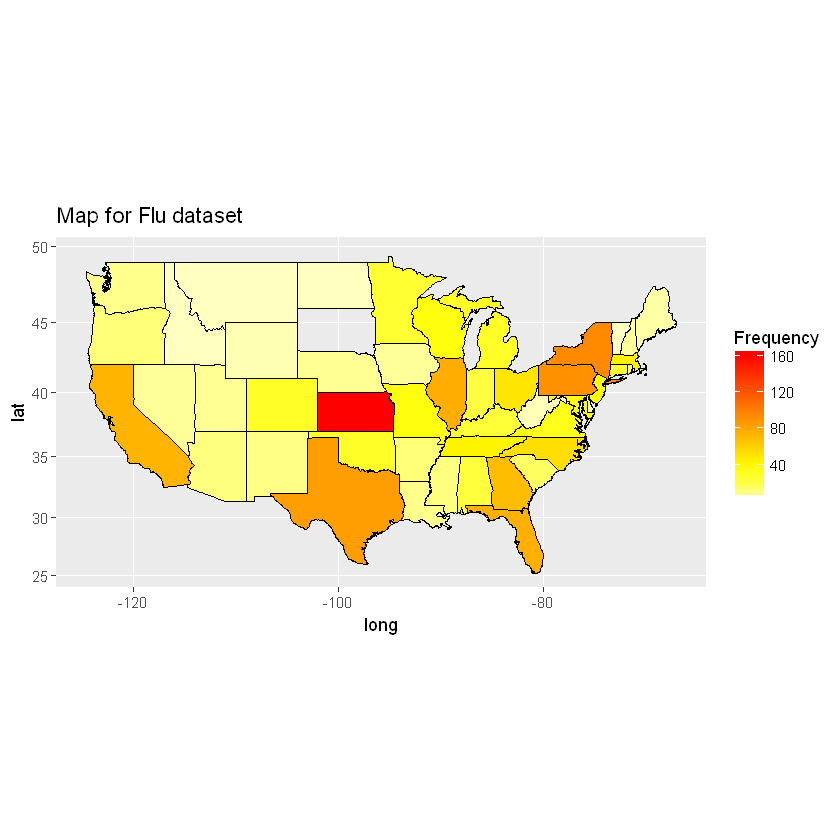

In [13]:
# Finally we have all the count of tweets state-wise in statedata. We use this data to plot the map using 
# ggplot and other map functions. We have referred https://stackoverflow.com/questions/24441775/how-do-you-create-a-us-states-heatmap-based-on-some-values
# Map for Flu dataset


flu_statedata$region <- tolower(flu_statedata$StateName)
states <- map_data("state")
map.df <- merge(states,flu_statedata, by="region", all.flu_statedata=T)
map.df <- map.df[order(map.df$order),]
ggplot(map.df, aes(x=long,y=lat,group=group))+ ggtitle("Map for Flu dataset")+
  geom_polygon(aes(fill=Frequency))+
  geom_path()+ 
  scale_fill_gradientn(colours=rev(heat.colors(10)),na.value="grey90")+
  coord_map()

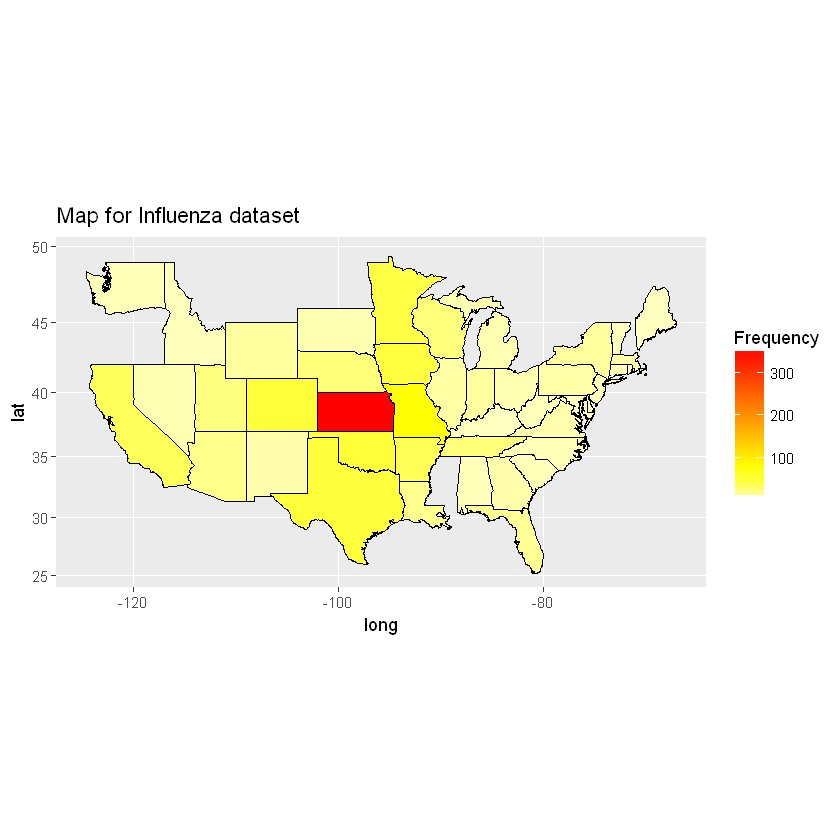

In [14]:
# Map for Influenza dataset

influenza_statedata$region <- tolower(influenza_statedata$StateName)
states <- map_data("state")
map.df <- merge(states,influenza_statedata, by="region", all.influenza_statedata=T)
map.df <- map.df[order(map.df$order),]
ggplot(map.df, aes(x=long,y=lat,group=group))+
  geom_polygon(aes(fill=Frequency))+
  geom_path()+ ggtitle("Map for Influenza dataset") +
  scale_fill_gradientn(colours=rev(heat.colors(10)),na.value="grey90")+
  coord_map()